In [1]:
# basic libraries
import numpy as np
import pandas as pd
from pandas import Series, DataFrame

# math and scipy
import math
import scipy.sparse as sp

# visualization
import matplotlib.pyplot as plt
import seaborn as sns
import cufflinks as cf
import plotly.express as px
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot

cf.go_offline()
init_notebook_mode(connected = True)
sns.set_style('whitegrid')
%matplotlib inline

# scikit-learn
from sklearn.model_selection import train_test_split
from sklearn.metrics.pairwise import pairwise_distances
from sklearn import metrics 

In [2]:
# dataset
columns_names = ['user_id', 'item_id', 'rating', 'timestamp']
movie_data = pd.read_csv('u.data', sep = '\t', names = columns_names)
movie_data.head()

,user_id,item_id,rating,timestamp
0,0,50,5,881250949
1,0,172,5,881250949
2,0,133,1,881250949
3,196,242,3,881250949
4,186,302,3,891717742


In [3]:
# movie titles dataset
movie_titles = pd.read_csv('Movie_Id_Titles')
movie_titles.head()

,item_id,title
0,1,Toy Story (1995)
1,2,GoldenEye (1995)
2,3,Four Rooms (1995)
3,4,Get Shorty (1995)
4,5,Copycat (1995)


In [4]:
# merging movie and movie titles dataset
movies = pd.merge(movie_data, movie_titles, on = 'item_id')
movies.head()

,user_id,item_id,rating,timestamp,title
0,0,50,5,881250949,Star Wars (1977)
1,290,50,5,880473582,Star Wars (1977)
2,79,50,4,891271545,Star Wars (1977)
3,2,50,5,888552084,Star Wars (1977)
4,8,50,5,879362124,Star Wars (1977)


In [5]:
# number of users and number of movies
print('Num. of Users: {}\nNum of Movies: {}'.format(movies.user_id.nunique(), movies.item_id.nunique()))

Num. of Users: 944
Num of Movies: 1682


In [6]:
# the highest rating on average
movies.groupby('title')['rating'].mean().sort_values(ascending = False).head()

title
Marlene Dietrich: Shadow and Light (1996)     5.0
Prefontaine (1997)                            5.0
Santa with Muscles (1996)                     5.0
Star Kid (1997)                               5.0
Someone Else's America (1995)                 5.0
Name: rating, dtype: float64

In [7]:
# the most ratings
movies.groupby('title')['rating'].count().sort_values(ascending = False).head()

title
Star Wars (1977)             584
Contact (1997)               509
Fargo (1996)                 508
Return of the Jedi (1983)    507
Liar Liar (1997)             485
Name: rating, dtype: int64

In [8]:
# making ratings dataframe
ratings = pd.DataFrame(movies.groupby('title')['rating'].mean())
ratings['num of ratings'] = pd.DataFrame(movies.groupby('title')['rating'].count())
ratings.head()

,rating,num of ratings
title,,
'Til There Was You (1997),2.333333,9
1-900 (1994),2.600000,5
101 Dalmatians (1996),2.908257,109
12 Angry Men (1957),4.344000,125
187 (1997),3.024390,41


In [9]:
# num of ratings distribution
px.histogram(ratings, x = 'num of ratings', nbins = 50, labels = {
    'x': 'num of ratings', 
    'y': 'count'
})

In [10]:
# rating distribution
px.histogram(ratings, x = 'rating', nbins = 50, labels = {
    'x': 'rating', 
    'y': 'count'
})

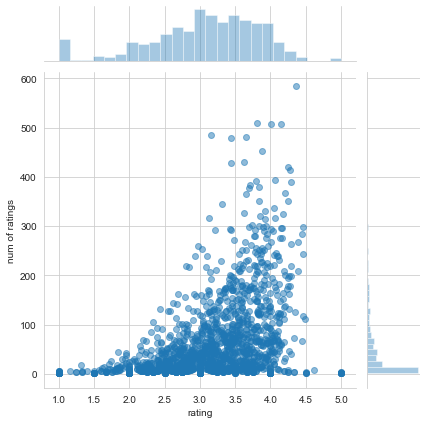

In [11]:
# rating vs num of ratings
sns.jointplot(x = 'rating', y = 'num of ratings', data = ratings, alpha = 0.5)

In [12]:
# creating a matrix for movies
movie_mat = movies.pivot_table(index = 'user_id', columns = 'title', values = 'rating')
movie_mat.head()

title,'Til There Was You (1997),1-900 (1994),101 Dalmatians (1996),12 Angry Men (1957),187 (1997),2 Days in the Valley (1996),"20,000 Leagues Under the Sea (1954)",2001: A Space Odyssey (1968),3 Ninjas: High Noon At Mega Mountain (1998),"39 Steps, The (1935)",...,Yankee Zulu (1994),Year of the Horse (1997),You So Crazy (1994),Young Frankenstein (1974),Young Guns (1988),Young Guns II (1990),"Young Poisoner's Handbook, The (1995)",Zeus and Roxanne (1997),unknown,Á köldum klaka (Cold Fever) (1994)
user_id,,,,,,,,,,,,,,,,,,,,,
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,2.0,5.0,NaN,NaN,3.0,4.0,NaN,NaN,...,NaN,NaN,NaN,5.0,3.0,NaN,NaN,NaN,4.0,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,2.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


A lot of missing values in the data. Movies with a lot of ratings will be picked.

In [13]:
# sorting num of ratings
ratings.sort_values('num of ratings', ascending = False).head()

,rating,num of ratings
title,,
Star Wars (1977),4.359589,584
Contact (1997),3.803536,509
Fargo (1996),4.155512,508
Return of the Jedi (1983),4.007890,507
Liar Liar (1997),3.156701,485


In [14]:
# picking starwars and liar liar
starwars_user_ratings = movie_mat['Star Wars (1977)']
liarliar_user_ratings = movie_mat['Liar Liar (1997)']
print(starwars_user_ratings.head(), liarliar_user_ratings.head())

user_id
0    5.0
1    5.0
2    5.0
3    NaN
4    5.0
Name: Star Wars (1977), dtype: float64 user_id
0    NaN
1    NaN
2    1.0
3    2.0
4    5.0
Name: Liar Liar (1997), dtype: float64


In [15]:
# correlate starwars user rating with other movies
similar_to_starwars = movie_mat.corrwith(starwars_user_ratings)
similar_to_starwars

D:\Applications\Anaconda\lib\site-packages\numpy\lib\function_base.py:2522: RuntimeWarning:

Degrees of freedom <= 0 for slice

D:\Applications\Anaconda\lib\site-packages\numpy\lib\function_base.py:2451: RuntimeWarning:

divide by zero encountered in true_divide



title
'Til There Was You (1997)                                   0.872872
1-900 (1994)                                               -0.645497
101 Dalmatians (1996)                                       0.211132
12 Angry Men (1957)                                         0.184289
187 (1997)                                                  0.027398
2 Days in the Valley (1996)                                 0.066654
20,000 Leagues Under the Sea (1954)                         0.289768
2001: A Space Odyssey (1968)                                0.230884
3 Ninjas: High Noon At Mega Mountain (1998)                      NaN
39 Steps, The (1935)                                        0.106453
8 1/2 (1963)                                               -0.142977
8 Heads in a Duffel Bag (1997)                             -0.577350
8 Seconds (1994)                                           -0.755929
A Chef in Love (1996)                                       0.868599
Above the Rim (1994)        

In [16]:
# transform the correlation data into data frame
corr_starwars = pd.DataFrame(similar_to_starwars, columns = ['Correlation'])
corr_starwars.dropna(inplace = True)
corr_starwars.sort_values('Correlation', ascending = False).head(10)

,Correlation
title,
Commandments (1997),1.0
Cosi (1996),1.0
No Escape (1994),1.0
Stripes (1981),1.0
Man of the Year (1995),1.0
Hollow Reed (1996),1.0
"Beans of Egypt, Maine, The (1994)",1.0
"Good Man in Africa, A (1994)",1.0
"Old Lady Who Walked in the Sea, The (Vieille qui marchait dans la mer, La) (1991)",1.0


The information from the data frame is nonsense as the movies are not popular at that period of time. The users who review the movies might also be rated by only one person who also rate Star Wars (1977) 5 stars. As a result, num of ratings minimum threshold has to be made.

In [17]:
# joining the corr_starwars data frame with num of ratings
corr_starwars = corr_starwars.join(ratings['num of ratings'])
corr_starwars.head()

,Correlation,num of ratings
title,,
'Til There Was You (1997),0.872872,9
1-900 (1994),-0.645497,5
101 Dalmatians (1996),0.211132,109
12 Angry Men (1957),0.184289,125
187 (1997),0.027398,41


In [18]:
# filtering num of ratings
corr_starwars[corr_starwars['num of ratings'] > 100].sort_values('Correlation', ascending = False).head(10)

,Correlation,num of ratings
title,,
Star Wars (1977),1.000000,584
"Empire Strikes Back, The (1980)",0.748353,368
Return of the Jedi (1983),0.672556,507
Raiders of the Lost Ark (1981),0.536117,420
Austin Powers: International Man of Mystery (1997),0.377433,130
"Sting, The (1973)",0.367538,241
Indiana Jones and the Last Crusade (1989),0.350107,331
Pinocchio (1940),0.347868,101
"Frighteners, The (1996)",0.332729,115


In [19]:
# correlate liar liar user rating with other movies
similar_to_liarliar = movie_mat.corrwith(liarliar_user_ratings)
similar_to_liarliar

D:\Applications\Anaconda\lib\site-packages\numpy\lib\function_base.py:2522: RuntimeWarning:

Degrees of freedom <= 0 for slice

D:\Applications\Anaconda\lib\site-packages\numpy\lib\function_base.py:2451: RuntimeWarning:

divide by zero encountered in true_divide



title
'Til There Was You (1997)                                   0.118913
1-900 (1994)                                                     NaN
101 Dalmatians (1996)                                       0.469765
12 Angry Men (1957)                                         0.066272
187 (1997)                                                  0.175145
2 Days in the Valley (1996)                                 0.040739
20,000 Leagues Under the Sea (1954)                        -0.027932
2001: A Space Odyssey (1968)                               -0.057864
3 Ninjas: High Noon At Mega Mountain (1998)                      NaN
39 Steps, The (1935)                                        0.400918
8 1/2 (1963)                                                0.178064
8 Heads in a Duffel Bag (1997)                                   NaN
8 Seconds (1994)                                                 NaN
A Chef in Love (1996)                                       0.000000
Above the Rim (1994)        

In [20]:
# transform the correlation data into data frame
corr_liarliar = pd.DataFrame(similar_to_liarliar, columns = ['Correlation'])
corr_liarliar.dropna(inplace = True)
corr_liarliar = corr_liarliar.join(ratings['num of ratings'])
corr_liarliar[corr_liarliar['num of ratings'] > 100].sort_values('Correlation', ascending = False).head(10)

,Correlation,num of ratings
title,,
Liar Liar (1997),1.000000,485
Batman Forever (1995),0.516968,114
"Mask, The (1994)",0.484650,129
Down Periscope (1996),0.472681,101
Con Air (1997),0.469828,137
Pretty Woman (1990),0.469790,164
101 Dalmatians (1996),0.469765,109
Michael (1996),0.442022,119
Waterworld (1995),0.438405,102


In [21]:
# splitting the data
train_data, test_data = train_test_split(movies, test_size = 0.25)

### Memory-Based Collaborative Filtering

In [22]:
# create two user-item matrices, one for training and another for testing
n_users = movies.user_id.nunique()
n_items = movies.item_id.nunique()

train_data_matrix = np.zeros((n_users, n_items))
for line in train_data.itertuples():
    train_data_matrix[line[1] - 1, line[2] - 1] = line[3]  

test_data_matrix = np.zeros((n_users, n_items))
for line in test_data.itertuples():
    test_data_matrix[line[1] - 1, line[2] - 1] = line[3]

In [23]:
# calculate cosine similarity
user_similarity = pairwise_distances(train_data_matrix, metric = 'cosine')
item_similarity = pairwise_distances(train_data_matrix.T, metric = 'cosine')

Pairwise distanes function is used to calculate the cosine similarity. The output will range from 0 to 1 since the ratins are all positive.

In [24]:
# predicting function
def predict(ratings, similarity, type = 'user'):
    if type == 'user':
        mean_user_rating = ratings.mean(axis=1)
        ratings_diff = (ratings - mean_user_rating[:, np.newaxis]) 
        prediction = mean_user_rating[:, np.newaxis] + similarity.dot(ratings_diff) / np.array([np.abs(similarity).sum(axis=1)]).T
    elif type == 'item':
        prediction = ratings.dot(similarity) / np.array([np.abs(similarity).sum(axis=1)])     
    return prediction

The predict function is made to predict the similarities for users and items whereby ratings are normalized, so that the ratings stay between 1 and 5. Using formulae:
<br>
<br>
$$\hat{x}_{k,m} = \bar{x}_{k} +  \frac{\sum\limits_{u_a}sim_u(u_k,u_a)(x_{a,m}-\bar{x_{u_a}})}{\sum\limits_{u_a}|sim_u(u_k,u_a)|},$$

where k and a are weights that are multiplied by the ratings of a similar user a (corrected for the average rating of that user), it is important to handle the tendency of users giving high or low ratings to all movies.In this function, np.newaxis is used, so that mean_user_rating has same format as ratings.

In [25]:
# predicting items and users similarities
item_prediction = predict(train_data_matrix, item_similarity, type = 'item')
user_prediction = predict(train_data_matrix, user_similarity, type = 'user')

In [26]:
# root mean squared error function
def rmse(prediction, ground_truth):
    prediction = prediction[ground_truth.nonzero()].flatten() 
    ground_truth = ground_truth[ground_truth.nonzero()].flatten()
    return math.sqrt(metrics.mean_squared_error(prediction, ground_truth))

In [27]:
# evaluation
print('User-based Memory-Based Collaborative Filtering RMSE: {}\nItem-based Memory-Based Collaborative Filtering RMSE: {}'.format(rmse(user_prediction, test_data_matrix), rmse(item_prediction, test_data_matrix)))

User-based Memory-Based Collaborative Filtering RMSE: 3.1241612076540353
Item-based Memory-Based Collaborative Filtering RMSE: 3.4518403753298545


### Model-Based Collaborative Filtering

In [28]:
# sparsity level
sparsity = round(1.0 - len(movies)/float(n_users * n_items), 3)
print('The sparsity level: {}%'.format(sparsity * 100))

The sparsity level: 93.7%


In [29]:
# getting Singular Value Decomposition components from train matrix 
u, s, vt = sp.linalg.svds(train_data_matrix, k = 20)
s_diag_matrix = np.diag(s)
x_pred = np.dot(np.dot(u, s_diag_matrix), vt)
print('User-based Collaborative Filtering MSE: {}'.format(rmse(x_pred, test_data_matrix)))

User-based Collaborative Filtering MSE: 2.7144618651021575


Matrix X can be factorised to U, S, and V, after which U, S, and V are predicted using this equation:
<br>
<br>
$$ X = USV^T $$

where
* *X* is an *(m x n)* matrix,
* *U* is an *(m x r)* orthogonal matrix representing the feature vectors corresponding to the users in the hidden feature space,
* *S* is an *(r x r)* diagonal matrix with non-negative real numbers on the diagonal in which elements on the diagonal are known as *singular values of X,
* *V^T* is an *(r x n)* orthogonal matrix representing the feature vectors corresponding to the items in the hidden feature space.